In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math, time, os, datetime, psutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
import random
from memory_profiler import memory_usage
import gc

In [2]:
col='CallIn'
n_grids=2

In [3]:
# Loading datad
df_train = pd.read_parquet(f"../data/train_data_2025-06-26_17-16-54.parquet")
df_test = pd.read_parquet(f"../data/test_data_scaled_2025-06-26_17-16-54.parquet")
df_eval = pd.read_parquet(f"../data/eval_data_scaled_2025-06-26_17-16-54.parquet")
#df_noisy_data = pd.read_parquet(f"../data/noisy_data")

In [4]:
FEATURES = [col, 'month', 'day_of_month', 'day_of_week', 'hour', 'minute']
TIMESTEPS = 24

In [5]:
# df_train=df_train[['gridID', col]]
# df_test=df_test[['gridID', col]]
# df_eval=df_eval[['gridID', col]]

<Axes: xlabel='startTime'>

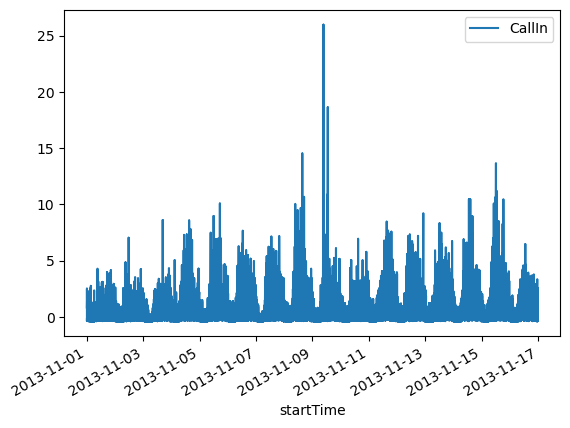

In [6]:
df_test[[col]].plot()

In [175]:
def add_gaussian_noise(series, mean=0, std=2):
    noise = np.random.randn(len(series)) * std + mean
    return series + noise

def split_signal(signal, num_of_splits):
    return np.concatenate(np.array_split(signal, num_of_splits))

def find_valid_splits(array_length):
    return [i for i in range(1, array_length + 1) if array_length % i == 0]


def plot_df(df, col, status=True):
    for grid in df['gridID'].unique():
        df_plt= df[df['gridID']==grid].drop(columns='gridID')
        plt.plot(df_plt.index, df_plt[col], label=f'{col} usage')
        if(status is True):
            colors = df_plt['status'].apply(lambda x: 'red' if x == 'Abnormal' else 'blue')
            plt.scatter(
            df_plt[df_plt['status'] == 'Abnormal'].index,
            df_plt[df_plt['status'] == 'Abnormal'][col],
            c='red',
            label='Abnormal')
        plt.xticks(rotation=45)
        plt.title(f"Grid: {grid}")
        plt.legend()
        plt.tight_layout()
        plt.show()


# ===========================
# Monitor wrapper function
# ===========================
def run_with_memory_and_time(func, *args, **kwargs):
    start_time = time.time()
    mem_usage, result = memory_usage(
        (func, args, kwargs), retval=True, max_usage=True
    )
    duration = time.time() - start_time
    return result, duration, mem_usage  # returns (function result, time in seconds, peak memory in MB)
    
# def fit_sarima(df, col, freq='10min'):
#     # Step 2: Fit SARIMA to the aggregated series
#     results = {}
    
#     for grid_id, group in df.groupby('gridID'):
    
#         print('Processing')
#         # Ensure proper time sorting
#         group = group.sort_index()
#         # group = group[col].asfreq(freq)
#         group.index.freq = freq
        
#         # Set Time as index (if not already)
#         # group = group.set_index('Time')
    
#         # Choose the target column
#         y = group[col]  # or any other variable
    
#         # Fit SARIMAX (simple example — adjust order/seasonal_order per your data)
#         try:
#             model = SARIMAX(
#                 y,
#                 order=order,              # ARIMA(p,d,q)
#                 seasonal_order=seasonal_order, # SARIMA(P,D,Q,s), s=seasonal period
#                 enforce_stationarity=False,
#                 enforce_invertibility=False
#             )
#             model_fit = model.fit(disp=False, maxiter=50)
#             results[grid_id] = model_fit
#             print(f"Fitted model for grid {grid_id}")
#         except Exception as e:
#             print(f"Error for grid {grid_id}: {e}")
#     return(results)



def fit_sarima(df, col, freq='10min', order=(1, 0, 0), seasonal_order=(1, 0, 0, 144)):
    results = {}
    resource_logs = []

    for grid_id, group in df.groupby('gridID'):
        print(f"Processing grid {grid_id}...")
        group = group.sort_index()
        group.index.freq = freq  # Set frequency explicitly

        y = group[col]

        def fit_model():
            model = SARIMAX(
                y,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            return model.fit(disp=False, maxiter=50)

        try:
            model_fit, train_time, peak_mem = run_with_memory_and_time(fit_model)
            results[grid_id] = model_fit

            print(f"✔ Grid {grid_id} trained in {train_time:.2f}s | Peak Mem: {peak_mem:.2f} MB")

            resource_logs.append({
                'gridID': grid_id,
                'column': col,
                'training_time_sec': round(train_time, 2),
                'peak_memory_MB': round(peak_mem, 2),
                'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            })

        except Exception as e:
            print(f"❌ Grid {grid_id} failed: {e}")
            continue

    # Create stats DataFrame
    df_stats = pd.DataFrame(resource_logs)

    print(df_stats)

    return results, df_stats




def predict_sarima_per_grid(df, col, model_list, freq='10min', forecast=True):
    predicted_all = []
    resource_logs = []

    for grid in df['gridID'].unique():
        group = df[df['gridID'] == grid].sort_index()
        ts_test = group[col].asfreq(freq)
        
        # Skip empty time series
        if ts_test.empty:
            print(f"Grid {grid} skipped: no data available.")
            continue

        # Skip if no model
        if grid not in model_list or model_list[grid] is None:
            print(f"Grid {grid} skipped: no model available.")
            continue

        # print(f'Grid id: {grid}')
        model = model_list[grid]

        def run_forecast():
            steps = len(ts_test)
            return model.forecast(steps=steps)

        def run_prediction():
            return model.predict(start=ts_test.index[0], end=ts_test.index[-1])

        try:
            if(bool(forecast)):
                predicted, pred_time, peak_mem = run_with_memory_and_time(run_prediction)
                y_true = ts_test
                y_pred = predicted
                
            else:
                predicted, pred_time, peak_mem = run_with_memory_and_time(run_prediction)
                # Align prediction with actuals
                y_true, y_pred = ts_test.align(predicted, join='inner')
                
            residuals = y_true - y_pred
            
            # Compute 95th percentile threshold
            threshold = np.mean(np.abs(residuals)) + 2.5 * np.std(np.abs(residuals))
            print(f'Threshold: {threshold}')

            df_pred = pd.DataFrame({
                'timestamp': y_true.index,
                'gridID': grid,
                'threshold': threshold,
                'actual': y_true.values,
                'predicted': y_pred.values,
                'residual': residuals.values,
                'status': np.where(np.abs(residuals) > threshold, 'Abnormal', 'Normal')
            })

            predicted_all.append(df_pred)

            resource_logs.append({
                'gridID': grid,
                'column': col,
                'prediction_time_sec': round(pred_time, 2),
                'peak_memory_MB': round(peak_mem, 2),
                'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'anomalies_detected': (df_pred['status'] == 'Abnormal').sum()
            })

            print(f"Grid {grid}: {df_pred['status'].value_counts().to_dict()} | Time: {pred_time:.2f}s | Mem: {peak_mem:.2f} MB")

        except Exception as e:
            print(f"Grid {grid} failed: {e}")

    # Handle case where no predictions succeeded
    if predicted_all:
        return pd.concat(predicted_all, ignore_index=True), pd.DataFrame(resource_logs)
    else:
        print("No valid predictions were made.")
        return pd.DataFrame(), pd.DataFrame(resource_logs)



# def predict_sarima(df, col, model, freq='10min'):
#     predicted_all = []
    
#     for grid in df['gridID'].unique():
#         group = df[df['gridID'] == grid].sort_index()
#         ts_test = group[col].asfreq(freq)
    
#         try:
#             # Predict using pre-trained SARIMA model
#             predicted = model.predict(start=ts_test.index[0], end=ts_test.index[-1])
    
#             # Align prediction with actuals
#             y_true, y_pred = ts_test.align(predicted, join='inner')
#             residuals = y_true - y_pred
    
#             # Compute threshold from residuals
#             threshold = np.percentile(np.abs(residuals), 95)
    
#             # Create full DataFrame for this grid
#             df_pred = pd.DataFrame({
#                 'timestamp': y_true.index,
#                 'gridID': grid,
#                 'actual': y_true.values,
#                 'predicted': y_pred.values,
#                 'residual': residuals.values,
#             })
    
#             # Add is_anomaly column
#             # df_pred['status'] = np.abs(df_pred['residual']) > threshold
#             df_pred['status'] = np.where(np.abs(df_pred['residual']) > threshold, 'Abnormal','Normal')

    
#             predicted_all.append(df_pred)
    
#             print(f"Grid {grid}: {(df_pred['status'] == 'Abnormal').sum()} anomalies detected.")
    
#         except Exception as e:
#             print(f"Grid {grid} failed: {e}")
#     return(predicted_all)


def add_noise_to_df(df, n_outliers=500, alpha_dev = 0.2, column_index=list(range(1, 6))):
    # Define the noisy region
    pos = int(np.round(len(find_valid_splits(len(df))) / 1.5))
    n_split = find_valid_splits(len(df))[pos]
    
    signal = split_signal(df.iloc[:, 1:6], n_split)  # columns 1–5 (assumes 0-based indexing)
    
    down = random.randint(0, signal.shape[0] - n_outliers)
    up = down + n_outliers
    print(f"Lower boundary {down} - Upper boundary {up}")
    
    # Apply Gaussian noise to each column (1 to 5)

    noisy_cols = []
    
    for col in df.columns[column_index]:
        orig_mean = df[col].mean()
        orig_std = df[col].std()
    
        noise_mean = orig_mean * (1 + alpha_dev)
        noise_std = orig_std * (1 + alpha_dev)
    
        # Apply noise only to selected rows
        signal_col = split_signal(df[col], n_split)
        noisy_part = add_gaussian_noise(signal_col[down:up], mean=noise_mean, std=noise_std)
    
        noisy_part = pd.Series(noisy_part, index=range(down, up))  # optional: specify index
    
        # Combine back into full series
        noisy_signal = pd.concat([
            df[col].iloc[:down],
            noisy_part,
            df[col].iloc[up:]
        ], ignore_index=True)
    
    
        noisy_cols.append(noisy_signal)
    
    # Construct new noisy DataFrame for columns 1–5
    noisy_df_part = pd.concat(noisy_cols, axis=1)
    noisy_df_part.columns = df.columns[column_index]
    
    # Combine with original DataFrame
    df_noisy = df.copy()
    df_noisy.iloc[:, column_index] = noisy_df_part
    
    ## Tracking the noise
    df_noisy['status'] = "Normal"
    df_noisy.iloc[down:up, df_noisy.columns.get_loc('status')] = "Abnormal"
    return(df_noisy, up, down)

In [176]:
# df_noisy = add_noise_to_df(df=df_test, n_outliers=1000, alpha_dev=0.2, column_index=list(range(1, 6)))

# df_noisy

In [177]:
df=df_train[['gridID', col]]

top_grid = df['gridID'].unique()[0:n_grids]

df= df[df['gridID'].isin(top_grid)]

df

,gridID,CallIn
startTime,,
2013-11-01 00:00:00,216,-0.386095
2013-11-01 00:00:00,1009,-0.393449
2013-11-01 00:10:00,1009,-0.386273
2013-11-01 00:10:00,216,-0.386095
2013-11-01 00:20:00,216,-0.386095
...,...,...
2013-11-16 23:30:00,216,-0.386095
2013-11-16 23:40:00,1009,-0.389440
2013-11-16 23:40:00,216,-0.389965


In [178]:
# plot_df(df, col=col, status=False)

In [179]:
# plot_df(df_noisy, col=col)

<Figure size 1200x400 with 0 Axes>

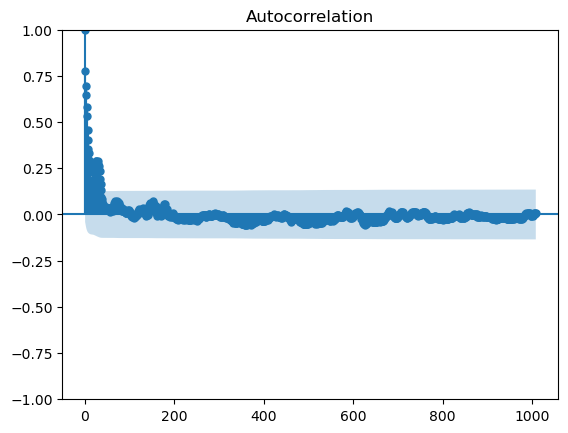

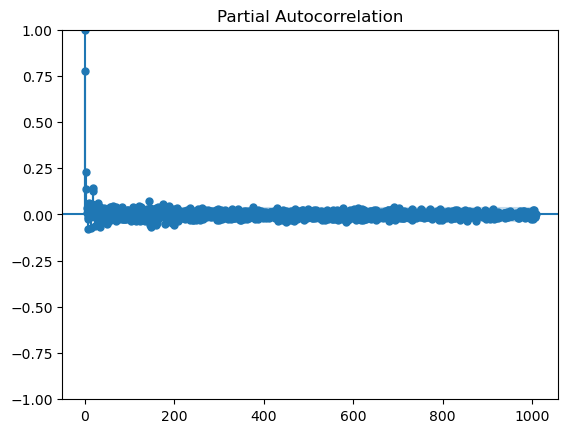

<Figure size 1200x400 with 0 Axes>

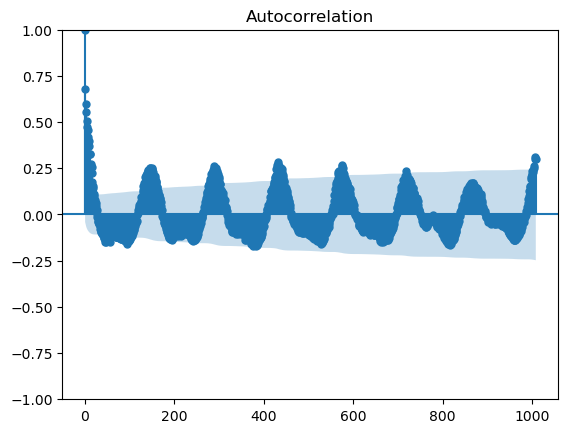

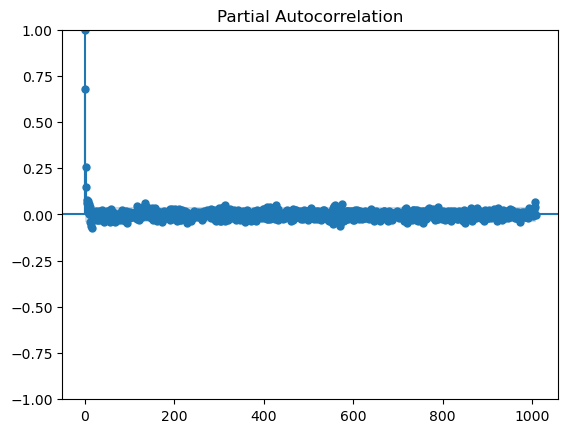

In [225]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
for grid in df['gridID'].unique():
    plt.figure(figsize=(12, 4))
    plot_acf(df[col][df['gridID']==grid], lags=144*7)     # Shows autocorrelation up to ~2 days
    plot_pacf(df[col][df['gridID']==grid], lags=144*7)
    plt.show()

In [229]:
order = (0, 0, 1)              # ARIMA part
seasonal_order = (0, 0, 1, 144)  # Seasonal part (daily seasonality for 10-min interval data)

In [ ]:
### Step 4: training mode
results, df_stats = fit_sarima(df=df, col=col, freq='10min', order=order, seasonal_order=seasonal_order)

Processing grid 216...
✔ Grid 216 trained in 103.16s | Peak Mem: 17902.91 MB
Processing grid 1009...


In [224]:
results[1009].aic

-12482.030434615188

In [228]:
gc.collect()

40743

In [211]:
# Save to CSV
timestamp1 = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

output_path = f"../results/train_stats_sarima_{timestamp1}_{col}.csv"
df_stats.to_csv(output_path, index=False)

In [212]:
df_noisy_1, up1, down1 = add_noise_to_df(df=df, n_outliers=100, alpha_dev=0.2, column_index=list(range(1, 2)))
df_noisy_2, up2, down2 = add_noise_to_df(df=df, n_outliers=200, alpha_dev=1, column_index=list(range(1, 2)))

Lower boundary 2478 - Upper boundary 2578
Lower boundary 1770 - Upper boundary 1970


/home/mfondoum/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/mfondoum/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/mfondoum/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/mfondoum/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [213]:
df_noisy = df_noisy_1
df_noisy[col][df_noisy['gridID']==216]=df_noisy_2[col][df_noisy_2['gridID']==216]

/tmp/ipykernel_1224842/4064927882.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_noisy[col][df_noisy['gridID']==216]=df_noisy_2[col][df_noisy_2['gridID']==216]
/tmp/ipykernel_1224842/4064927882.py:2: SettingWithCopyWarning: 
A value 

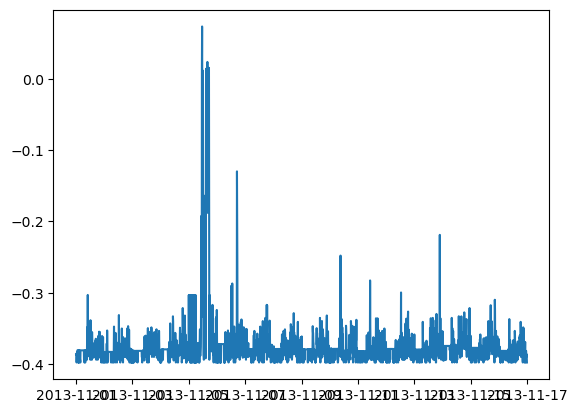

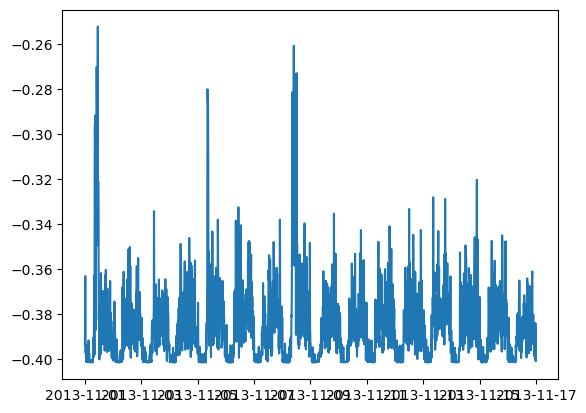

In [214]:
for grid in df['gridID'].unique():
    plt.plot(df[col][df['gridID']==grid])
    plt.show()

In [215]:
grids_eval_ids = df['gridID'].unique()

grids_eval_ids

# top_grid_test = df_noisy['gridID'].unique()[0:2]

df_test_mod = df_noisy[['gridID', col]][df_noisy['gridID'].isin(top_grid)]

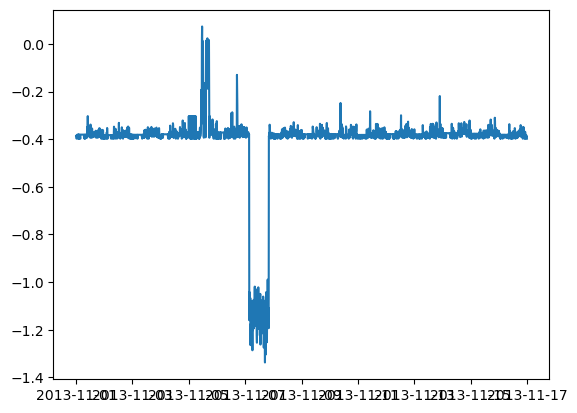

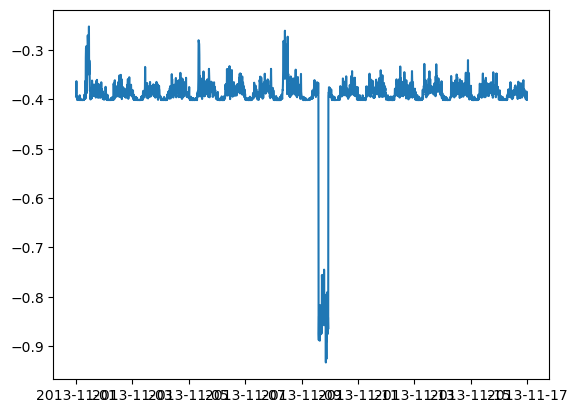

In [216]:
for grid in df_test_mod['gridID'].unique():
    plt.plot(df_test_mod[col][df_test_mod['gridID']==grid])
    plt.show()

In [217]:
# Prediction
predicted_all, df_stats = predict_sarima_per_grid(df=df_test_mod[['gridID', col]], col=col, model_list=results, freq='10min', forecast=False)

Threshold: 0.43460540911543466
Grid 216: {'Normal': 2204, 'Abnormal': 100} | Time: 0.75s | Mem: 12186.80 MB
Threshold: 0.1847054826711806
Grid 1009: {'Normal': 2253, 'Abnormal': 51} | Time: 0.55s | Mem: 12186.80 MB


In [218]:
df_stats

,gridID,column,prediction_time_sec,peak_memory_MB,timestamp,anomalies_detected
0,216,CallIn,0.75,12186.8,2025-06-28 13:46:53,100
1,1009,CallIn,0.55,12186.8,2025-06-28 13:46:53,51


In [203]:
# Save to CSV
timestamp1 = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_path = f"../results/test_stats_sarima_{timestamp1}_{col}.csv"
df_stats.to_csv(output_path, index=False)

In [204]:
predicted_all['actual_status'] = "Normal"
predicted_all['actual_status'].iloc[up1:down1]='Abnormal'
predicted_all['actual_status'].iloc[up2:down2]='Abnormal'

/tmp/ipykernel_1224842/316917723.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  predicted_all['actual_status'].iloc[up1:down1]='Abnormal'
/tmp/ipykernel_1224842/316917723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a c

In [205]:
# thresholds = predicted_all.groupby('gridID')['actual'].transform(lambda x: np.percentile(x, 95))

# predicted_all['actual_status'] = np.where(predicted_all['actual'] > thresholds, 'Abnormal', 'Normal')

In [206]:
predicted_all

,timestamp,gridID,actual,predicted,residual,status,actual_status
0,2013-11-01 00:00:00,216,-0.386095,0.000000,-0.386095,Normal,Normal
1,2013-11-01 00:10:00,216,-0.386095,-0.385008,-0.001087,Normal,Normal
2,2013-11-01 00:20:00,216,-0.386095,-0.385008,-0.001087,Normal,Normal
3,2013-11-01 00:30:00,216,-0.397706,-0.385008,-0.012698,Normal,Normal
4,2013-11-01 00:40:00,216,-0.389965,-0.396586,0.006621,Normal,Normal
...,...,...,...,...,...,...,...
4603,2013-11-16 23:10:00,1009,-0.390243,-0.389081,-0.001162,Normal,Normal
4604,2013-11-16 23:20:00,1009,-0.400202,-0.389708,-0.010494,Normal,Normal
4605,2013-11-16 23:30:00,1009,-0.383850,-0.400108,0.016259,Normal,Normal
4606,2013-11-16 23:40:00,1009,-0.389440,-0.383424,-0.006016,Normal,Normal


In [207]:
# Full predictions and residuals
error_test_df = predicted_all

In [208]:
metrics = []

for grid, group in error_test_df.groupby('gridID'):
    y_true = group['actual_status'].map({'Normal': 0, 'Abnormal': 1}).astype(int)
    y_pred = group['status'].map({'Normal': 0, 'Abnormal': 1}).astype(int)

    # Compute confusion matrix
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    except ValueError:
        tn = fp = fn = tp = float('nan')

    # Compute AUROC, if possible
    try:
        auroc = roc_auc_score(y_true, group['residual'].abs())
    except ValueError:
        auroc = float('nan')

    metrics.append({
        'gridID': grid,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0),
        'auroc': auroc,
        'true_positive': tp,
        'true_negative': tn,
        'false_positive': fp,
        'false_negative': fn
    })

In [209]:
timestamp1 = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
metrics_df = pd.DataFrame(metrics)
metrics_df

,gridID,accuracy,precision,recall,f1_score,auroc,true_positive,true_negative,false_positive,false_negative
0,216,0.956597,0.0,0.0,0.0,NaN,0,2204,100,0
1,1009,0.977865,0.0,0.0,0.0,NaN,0,2253,51,0


In [41]:
metrics_df.to_csv(f"../results/sarima_model_metrics_{col}_{timestamp1}.csv")

In [42]:
col

'CallIn'

## Forecasting

In [ ]:
# df_eval = df_eval.groupby('timestamp').agg({
#     'Internet': ['mean'],
#     #'timestamp':['min']
# }).rename(columns={'Internet mean': 'Internet'})

In [ ]:
# df_eval.columns=['Internet']

In [ ]:
# # 1. Ensure df_eval is sorted and evenly spaced
# df_eval = df_eval.sort_index()
# df_eval = df_eval.asfreq('10min')

# # 2. Forecast future values using the pre-trained model
# steps = len(df_eval)
# forecast = results.get_forecast(steps=steps)
# forecast_mean = forecast.predicted_mean

# # 3. Align forecast with actuals
# y_true, y_pred = df_eval['Internet'].align(forecast_mean, join='inner')
# residuals = y_true - y_pred

# # 4. Anomaly detection using 95th percentile of residuals
# threshold = np.percentile(np.abs(residuals), 95)
# is_anomaly = np.abs(residuals) > threshold

# # 5. Assign ground truth if you know rows 6167–6667 in df_eval are anomalies
# actual_status = np.zeros(len(y_true), dtype=bool)
# if len(y_true) > 6667:
#     actual_status[6167:6668] = True  # index-based anomaly range

# # 6. Compute metrics
# try:
#     auroc = roc_auc_score(actual_status, np.abs(residuals))
# except ValueError:
#     auroc = float('nan')

# metrics_eval = {
#     'accuracy': accuracy_score(actual_status, is_anomaly),
#     'precision': precision_score(actual_status, is_anomaly, zero_division=0),
#     'recall': recall_score(actual_status, is_anomaly, zero_division=0),
#     'f1_score': f1_score(actual_status, is_anomaly, zero_division=0),
#     'auroc': auroc
# }

In [ ]:
# metrics_eval_df = pd.DataFrame([metrics_eval])

In [ ]:
# forecast_eval_df = pd.DataFrame({
#     'timestamp': y_true.index,
#     'actual': y_true.values,
#     'predicted': y_pred.values,
#     'residual': residuals.values,
#     'is_anomaly': is_anomaly,
#     'actual_status': actual_status
# })

In [ ]:
# metrics_eval_df.to_csv(f"sarima_model_eval_metrics_{col}_{timestamp1}.csv")

In [ ]:
# forecast_eval_df.to_csv(f"sarima_forecast_eval_{col}_{timestamp1}.csv")

In [ ]:
# steps = 144 * 15  # 144 points per day × 7 days
# forecast = results.get_forecast(steps=steps)

# # Get predicted mean
# forecast_mean = forecast.predicted_mean

# ## Confidence interval
# conf_int = forecast.conf_int()

In [49]:
# plt.figure(figsize=(14, 4))
# plt.plot(anomaly_df['timestamp'], anomaly_df['residual'])
# plt.axhline(anomaly_df['residual'].mean(), color='red', linestyle='--', label='Threshold')
# plt.title(f'[col] Usage with SARIMA residuals')
# # plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [ ]:
# grid = all_anomalies['gridID'].unique()[0]
# subset = df[df['gridID'] == grid].sort_index()

# plt.figure(figsize=(14, 4))
# plt.plot(subset.index, subset['Internet'], label='Internet Usage')
# plt.scatter(all_anomalies[all_anomalies['gridID'] == grid]['timestamp'],
#             subset.loc[all_anomalies[all_anomalies['gridID'] == grid]['timestamp'], 'Internet'],
#             color='red', label='Anomalies', zorder=5)
# plt.title(f'Internet Usage with SARIMA Outliers (Grid {grid})')
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [ ]:
# ### Step 6: Anomaly detection

# threshold = np.percentile(reconstruction_error, 95)
# anomalies = reconstruction_error > threshold


In [ ]:
# # Create a DataFrame to group and plot
# error_df = pd.DataFrame({
#     'timestamp': timestamps_train,
#     'gridID': grids_train,
#     'reconstruction_error': reconstruction_error
# })

# # Optional: plot top N grids or all
# grids_to_plot = error_df['gridID'].unique()  # change slice to plot more/less

In [ ]:
# plt.figure(figsize=(14, 6))

# for grid in grids_to_plot:
#     subset = error_df[error_df['gridID'] == grid]
#     plt.plot(subset['timestamp'], subset['reconstruction_error'], label=f'Grid {grid}')

# plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
# plt.title("Reconstruction Error by Grid")
# plt.xlabel("Timestamp")
# plt.xticks(rotation=45)
# plt.ylabel("Reconstruction Error")
# plt.legend()
# plt.tight_layout()
# plt.show()

## test data

In [ ]:
# # Create test sequences
# seq_len = 144
# X_test, timestamps_test, grid_ids_test, row_indices_test = create_sequences_with_time(
#     df_test, seq_len=seq_len, return_meta=True)

# X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

In [ ]:
# model.eval()
# with torch.no_grad():
#     X_pred = model(X_test_tensor)
#     mse = nn.MSELoss(reduction='none')(X_pred, X_test_tensor)
#     reconstruction_error = mse.mean(dim=(1, 2)).cpu().numpy()

In [ ]:
# # Create a DataFrame to group and plot
# error_test_df = pd.DataFrame({
#     'timestamp': timestamps_test,
#     'gridID': grid_ids_test,
#     'reconstruction_error': reconstruction_error
# })

In [ ]:
# # Rename for clarity and join back
# grid_thresholds = grid_thresholds.rename('grid_threshold')

# # Merge with original DataFrame
# error_test_df = error_test_df.merge(grid_thresholds, on='gridID')

# # Identify anomalies based on grid-wise thresholds
# error_test_df['predicted'] = error_test_df['reconstruction_error'] > error_test_df['grid_threshold']

In [ ]:
# ## Ground True
# error_test_df['actual']=False
# error_test_df.loc[6167:6668, 'actual']=True

In [ ]:
# error_test_df

In [ ]:
# # Mark known anomalies in index 6167–6667
# anomaly_range = range(6167, 6668)

# ## Ground truth: 1 if sequence ends in known anomaly range, else 0
# y_true = np.zeros(len(X_test), dtype=int)
# y_true[6167:6668] = 1

# ## Predicted
# # Use threshold from training (e.g., 95th percentile)
# threshold = np.percentile(reconstruction_error, 95)
# y_pred = (reconstruction_error > threshold).astype(int)

In [ ]:
# plt.plot(reconstruction_error)
# plt.plot(error_test_df['grid_threshold'])

In [ ]:
# np.percentile(reconstruction_error, 85)

In [ ]:
# grids_to_plot = error_test_df['gridID'].unique()

# # error_test_df['grid_threshold'][error_test_df['gridID']==grids_to_plot[0]].unique()

In [ ]:
# plt.figure(figsize=(14, 6))

# for grid in grids_to_plot:
#     subset = error_test_df[error_test_df['gridID'] == grid]
#     plt.plot(subset['timestamp'], subset['reconstruction_error'], label=f'Grid {grid}')

# plt.axhline(subset['grid_threshold'].values[0], color='red', linestyle='--', label='Threshold')
# plt.title("Reconstruction Error by Grid")
# plt.xlabel("Timestamp")
# plt.xticks(rotation=45)
# plt.ylabel("Reconstruction Error")
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# for grid in grids_to_plot:
#     subset = error_test_df[error_test_df['gridID'] == grid]

#     plt.figure(figsize=(12, 4))
#     plt.plot(subset['timestamp'], subset['reconstruction_error'], label='Reconstruction Error')

#     # Grid-specific threshold
#     # threshold = subset['grid_threshold'].iloc[0]
#     threshold = np.percentile(error_test_df['reconstruction_error'], 90)
#     plt.axhline(threshold, color='red', linestyle='--', label='Threshold')

#     plt.title(f"Reconstruction Error for Grid {grid}")
#     plt.xlabel("Timestamp")
#     plt.ylabel("Reconstruction Error")
#     plt.xticks(rotation=45)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

In [ ]:
# y_pred = error_test_df['predicted']
# y_true = error_test_df['actual']

In [ ]:
# cm =confusion_matrix(y_true, y_pred)

In [ ]:
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Normal', 'Anomaly'],
#             yticklabels=['Normal', 'Anomaly'])

# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix - Anomaly Detection')
# plt.tight_layout()
# plt.show()

In [ ]:
# accuracy = accuracy_score(y_true, y_pred)
# precision = precision_score(y_true, y_pred, zero_division=0)
# recall = recall_score(y_true, y_pred, zero_division=0)
# f1 = f1_score(y_true, y_pred, zero_division=0)

# # AUROC — use raw scores, not thresholded predictions
# try:
#     auroc = roc_auc_score(y_true, y_pred)
# except ValueError:
#     auroc = float('nan')  # AUROC not defined if only 1 class is present

In [ ]:
# print(f"Accuracy:  {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall:    {recall:.4f}")
# print(f"F1-score:  {f1:.4f}")
# print(f"AUROC:     {auroc:.4f}")

In [ ]:
# timestamp2 = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [ ]:
# df_res = pd.DataFrame({"Variable":pd.Series(f'{col}'),
#                        "Accuracy":pd.Series(accuracy),
#                        "Precision":pd.Series(precision), 
#                        "Recall":pd.Series(recall), 
#                        "F1Score":pd.Series(f1), 
#                        "Auroc":pd.Series(auroc)})

In [ ]:
# df_res

In [ ]:
# df_res.to_csv(f'LSTM_results_{col}_timestamp2.csv')

In [ ]:
### Files to return
# LTSM_*_datetime.csv
# train_stats_*_datetime.txt
# testing_stats_*_datetime.txt